In [1]:

import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

import pandas as pd
import numpy as np


from PIL import Image

from skimage.feature import hog
from skimage.color import rgb2grey

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


from sklearn.model_selection import train_test_split


from sklearn.svm import SVC


from sklearn.metrics import roc_curve, auc, accuracy_score

,id,genus
0,100,0.0
1,101,0.0
2,102,0.0
3,103,0.0
4,104,0.0


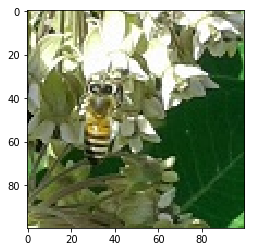

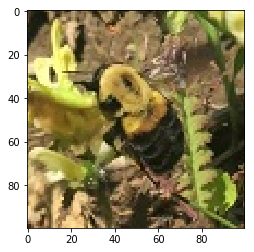

In [2]:

labels = pd.read_csv("datasets/labels.csv", index_col=0)


display(labels.head())

def get_image(row_id, root="datasets/"):
    """
    Converts an image number into the file path where the image is located, 
    opens the image, and returns the image as a numpy array.
    """
    filename = "{}.jpg".format(row_id)
    file_path = os.path.join(root, filename)
    img = Image.open(file_path)
    return np.array(img)


ferdivus_row = labels[labels.genus == 0.0].index[4]


plt.imshow(get_image(ferdivus_row))
plt.show()


grise_row = labels[labels.genus == 1.0].index[4]


plt.imshow(get_image(grise_row))
plt.show()

Color bombus image has shape:  (100, 100, 3)
Greyscale bombus image has shape:  (100, 100)


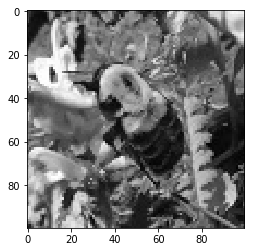

In [7]:

bombus = get_image(grise_row)


print('Color bombus image has shape: ', bombus.shape)


grey_bombus = rgb2grey(bombus)


plt.imshow(grey_bombus, cmap=mpl.cm.gray)


print('Greyscale bombus image has shape: ', grey_bombus.shape)

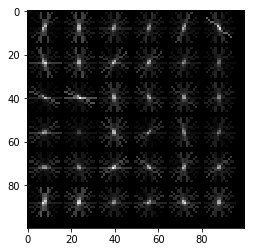

In [8]:

hog_features, hog_image = hog(grey_bombus,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))


plt.imshow(hog_image, cmap=mpl.cm.gray)

In [9]:
def create_features(img):
    
    color_features = img.flatten()
    
    grey_image = rgb2grey(img)
   
    hog_features = hog(grey_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    
    flat_features = np.hstack((color_features, hog_features))
    return flat_features

bombus_features = create_features(bombus)


print(bombus_features.shape)

(31296,)


In [10]:
def create_feature_matrix(label_dataframe):
    features_list = []
    
    for img_id in label_dataframe.index:
        
        img = get_image(img_id)
       
        image_features = create_features(img)
        features_list.append(image_features)
        
    
    feature_matrix = np.array(features_list)
    return feature_matrix


feature_matrix = create_feature_matrix(labels)

In [12]:

print('Feature matrix shape is: ', feature_matrix.shape)


ss = StandardScaler()

bees_stand = ss.fit_transform(feature_matrix)

pca = PCA(n_components=20)

bees_pca = pca.fit_transform(bees_stand)

print('PCA matrix shape is: ', bees_stand.shape)

Feature matrix shape is:  (20, 31296)
PCA matrix shape is:  (20, 31296)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(bees_pca,
                                                    labels.genus.values,
                                                    test_size=.3,
                                                    random_state=1234123)


pd.Series(y_train).value_counts()

0.0    7
1.0    7
dtype: int64

In [14]:

svm = SVC(kernel='linear', probability=True, random_state=42)


svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=42,
  shrinking=True, tol=0.001, verbose=False)

In [15]:

y_pred = svm.predict(X_test)


accuracy = accuracy_score(y_pred, y_test)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.8333333333333334


[0.54759007 0.5064394  0.48711529 0.54765942 0.52153547 0.5       ]


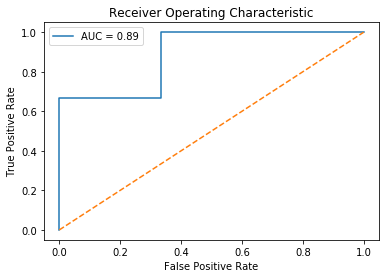

In [16]:

probabilities = svm.predict_proba(X_test)


y_proba = probabilities[:, 1]
print(y_proba)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label=1)


roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')

roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');